# Numpyro on CoCalc

examples taken from https://num.pyro.ai/en/latest/tutorials/bayesian_regression.html

In [23]:
import numpyro
numpyro.__version__

'0.8.0'

In [1]:
import os

from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

plt.style.use("bmh")
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

assert numpyro.__version__.startswith("0.8.0")

/usr/local/lib/python3.8/dist-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/usr/local/lib/python3.8/dist-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [2]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
dset = pd.read_csv(DATASET_URL, sep=";")
dset.head()

Location Loc  Population  MedianAgeMarriage  Marriage  Marriage SE  \
0     Alabama  AL        4.78               25.3      20.2         1.27   
1      Alaska  AK        0.71               25.2      26.0         2.93   
2     Arizona  AZ        6.33               25.8      20.3         0.98   
3    Arkansas  AR        2.92               24.3      26.4         1.70   
4  California  CA       37.25               26.8      19.1         0.39   

   Divorce  Divorce SE  WaffleHouses  South  Slaves1860  Population1860  \
0     12.7        0.79           128      1      435080          964201   
1     12.5        2.05             0      0           0               0   
2     10.8        0.74            18      0           0               0   
3     13.5        1.22            41      1      111115          435450   
4      8.0        0.24             0      0           0          379994   

   PropSlaves1860  
0            0.45  
1            0.00  
2            0.00  
3            0.26  
4            0.00

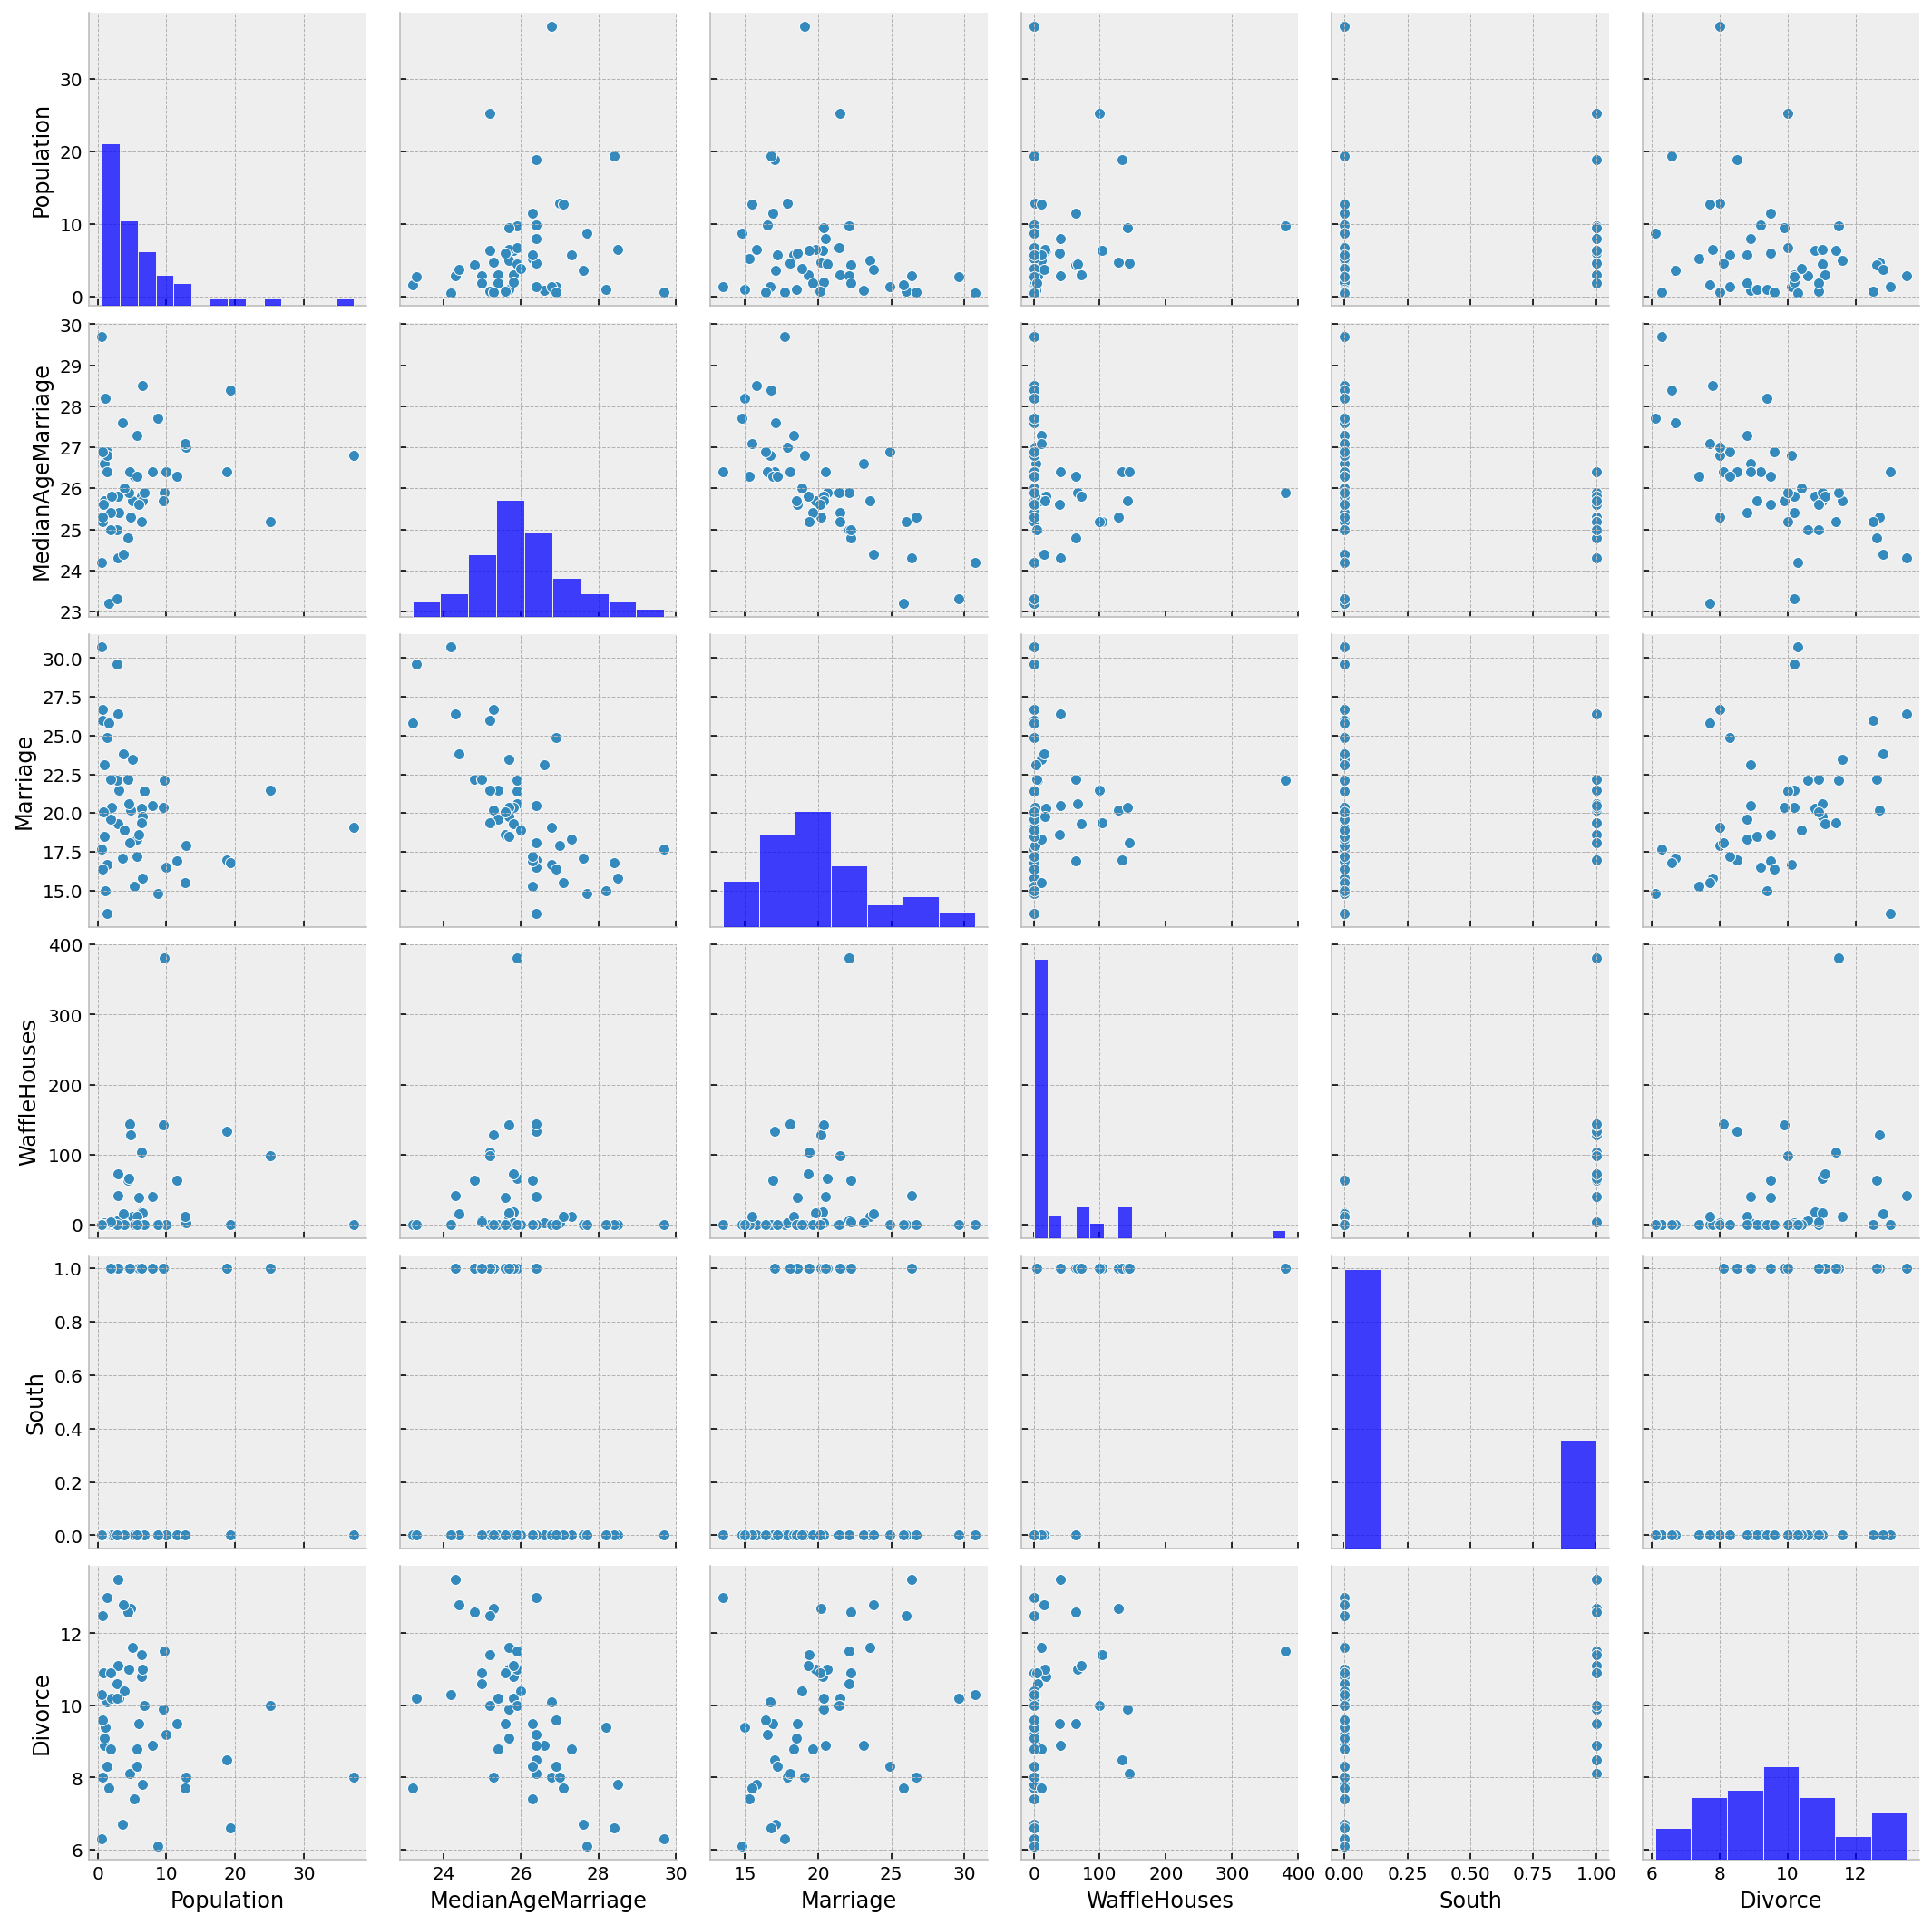

In [3]:
vars = [
    "Population",
    "MedianAgeMarriage",
    "Marriage",
    "WaffleHouses",
    "South",
    "Divorce",
]
sns.pairplot(dset, x_vars=vars, y_vars=vars, palette="husl");

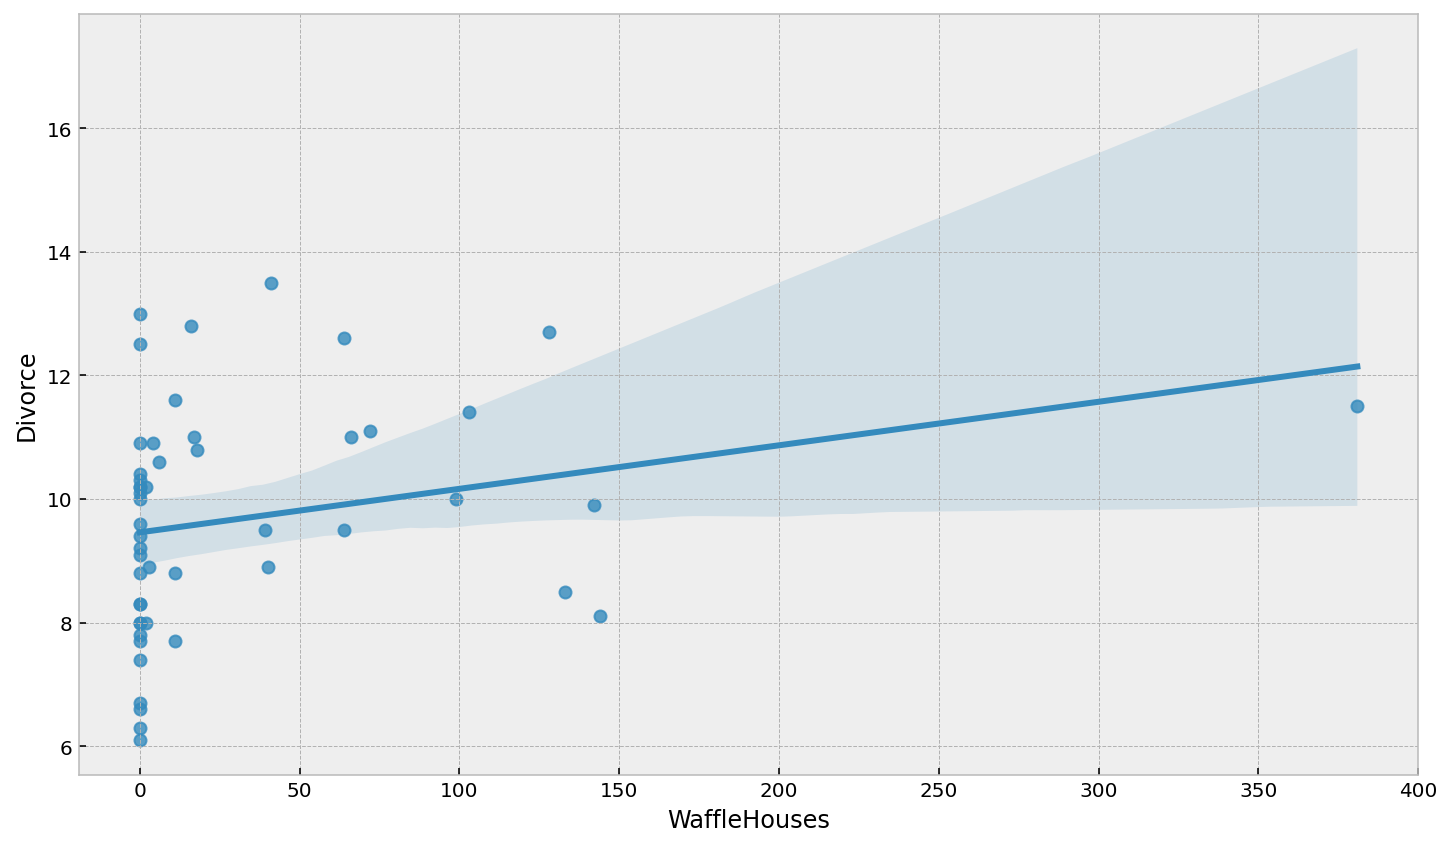

In [4]:
sns.regplot(x="WaffleHouses", y="Divorce", data=dset);

In [5]:
standardize = lambda x: (x - x.mean()) / x.std()

dset["AgeScaled"] = dset.MedianAgeMarriage.pipe(standardize)
dset["MarriageScaled"] = dset.Marriage.pipe(standardize)
dset["DivorceScaled"] = dset.Divorce.pipe(standardize)

In [6]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample("a", dist.Normal(0.0, 0.2))
    M, A = 0.0, 0.0
    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.0, 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample("bA", dist.Normal(0.0, 0.5))
        A = bA * age
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mu = a + M + A
    numpyro.sample("obs", dist.Normal(mu, sigma), obs=divorce)

In [7]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)
mcmc.run(
    rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values
)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:04<3:28:07,  4.16s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:  15%|█▍        | 446/3000 [00:04<00:17, 147.84it/s, 3 steps of size 7.09e-01. acc. prob=0.79]

warmup:  24%|██▎       | 708/3000 [00:04<00:08, 259.27it/s, 1 steps of size 1.79e+00. acc. prob=0.79]

warmup:  33%|███▎      | 999/3000 [00:04<00:04, 419.88it/s, 3 steps of size 2.06e+00. acc. prob=0.79]

sample:  44%|████▍     | 1325/3000 [00:04<00:02, 646.10it/s, 7 steps of size 7.86e-01. acc. prob=0.92]

sample:  54%|█████▍    | 1616/3000 [00:04<00:01, 871.34it/s, 7 steps of size 7.86e-01. acc. prob=0.92]

sample:  71%|███████   | 2128/3000 [00:04<00:00, 1409.25it/s, 7 steps of size 7.86e-01. acc. prob=0.92]

sample:  89%|████████▉ | 2676/3000 [00:04<00:00, 2032.01it/s, 3 steps of size 7.86e-01. acc. prob=0.92]

sample: 100%|██████████| 3000/3000 [00:04<00:00, 608.52it/s, 3 steps of size 7.86e-01. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.01      0.11      0.01     -0.17      0.19   1511.88      1.00
        bM      0.35      0.13      0.35      0.14      0.57   1694.14      1.00
     sigma      0.95      0.10      0.94      0.78      1.10   1696.30      1.00

Number of divergences: 0


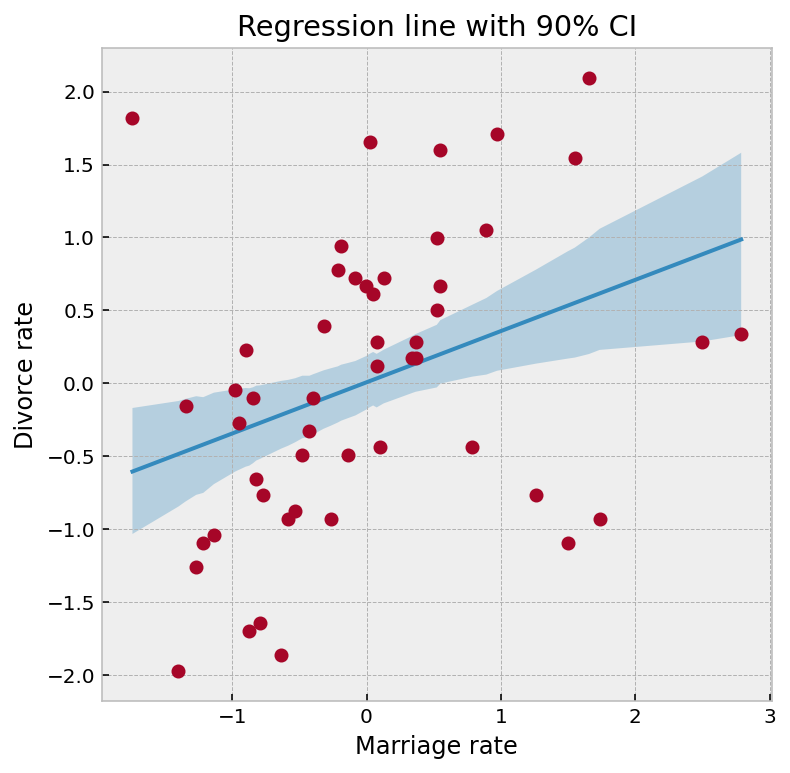

In [8]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax


# Compute empirical posterior distribution over mu
posterior_mu = (
    jnp.expand_dims(samples_1["a"], -1)
    + jnp.expand_dims(samples_1["bM"], -1) * dset.MarriageScaled.values
)

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI"
);

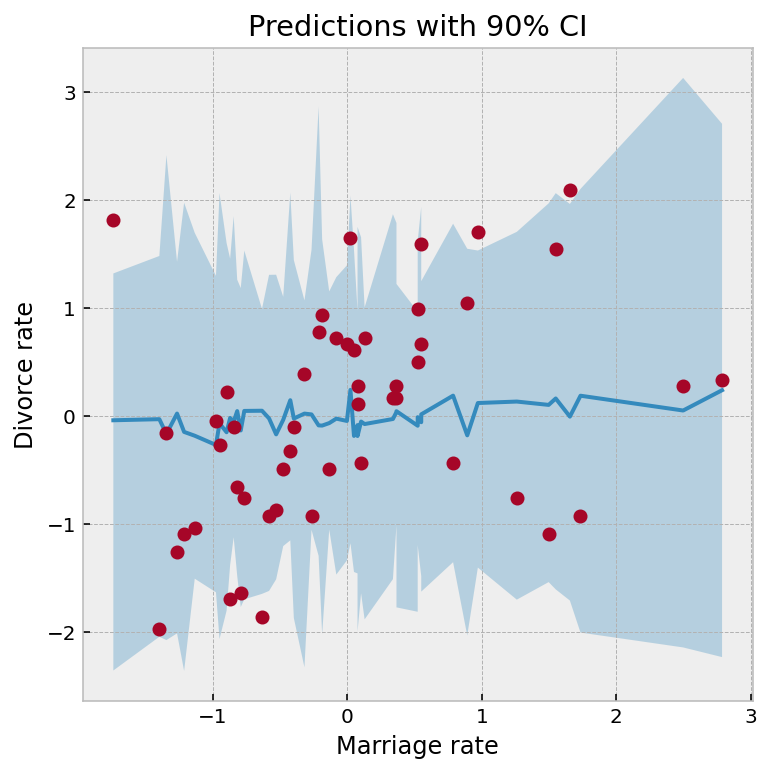

In [9]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)[
    "obs"
]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

In [10]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)["obs"]
df = dset.filter(["Location"])
df["Mean Predictions"] = jnp.mean(predictions, axis=0)
df.head()

Location  Mean Predictions
0     Alabama          0.020609
1      Alaska          0.510827
2     Arizona          0.024643
3    Arkansas          0.611333
4  California         -0.080117

In [11]:
def predict(rng_key, post_samples, model, *args, **kwargs):
    model = handlers.seed(handlers.condition(model, post_samples), rng_key)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    return model_trace["obs"]["value"]


# vectorize predictions via vmap
predict_fn = vmap(
    lambda rng_key, samples: predict(
        rng_key, samples, model, marriage=dset.MarriageScaled.values
    )
)

In [12]:
# Using the same key as we used for Predictive - note that the results are identical.

predictions_1 = predict_fn(random.split(rng_key_, num_samples), samples_1)

mean_pred = jnp.mean(predictions_1, axis=0)
df = dset.filter(["Location"])
df["Mean Predictions"] = mean_pred
df.head()

Location  Mean Predictions
0     Alabama          0.020609
1      Alaska          0.510827
2     Arizona          0.024643
3    Arkansas          0.611333
4  California         -0.080117

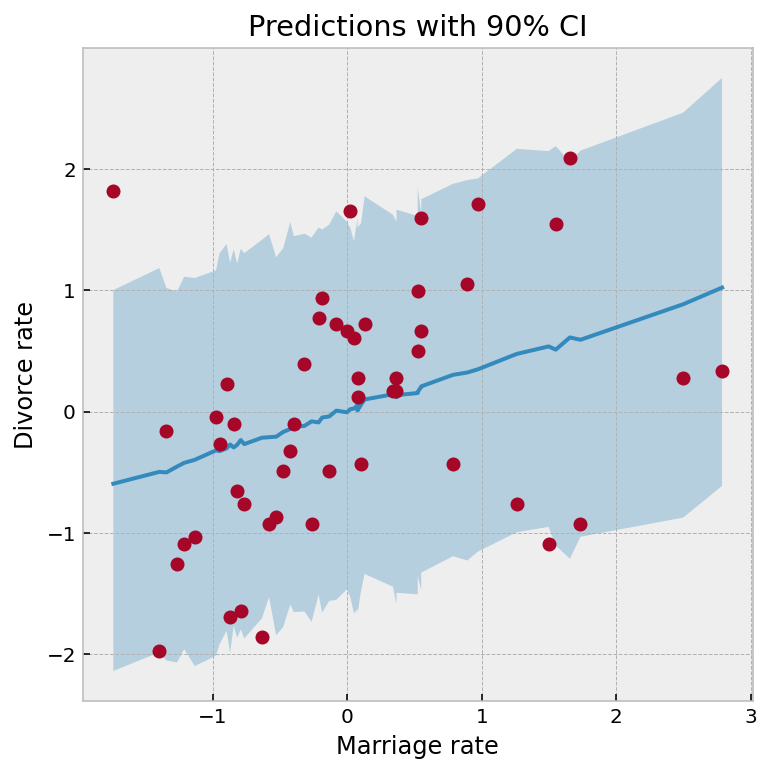

In [13]:
hpdi_pred = hpdi(predictions_1, 0.9)

ax = plot_regression(dset.MarriageScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");


In [14]:
def log_likelihood(rng_key, params, model, *args, **kwargs):
    model = handlers.condition(model, params)
    model_trace = handlers.trace(model).get_trace(*args, **kwargs)
    obs_node = model_trace["obs"]
    return obs_node["fn"].log_prob(obs_node["value"])


def log_pred_density(rng_key, params, model, *args, **kwargs):
    n = list(params.values())[0].shape[0]
    log_lk_fn = vmap(
        lambda rng_key, params: log_likelihood(rng_key, params, model, *args, **kwargs)
    )
    log_lk_vals = log_lk_fn(random.split(rng_key, n), params)
    return (logsumexp(log_lk_vals, 0) - jnp.log(n)).sum()

In [15]:
rng_key, rng_key_ = random.split(rng_key)
print(
    "Log posterior predictive density: {}".format(
        log_pred_density(
            rng_key_,
            samples_1,
            model,
            marriage=dset.MarriageScaled.values,
            divorce=dset.DivorceScaled.values,
        )
    )
)

Log posterior predictive density: -66.6878890991211


In [16]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(rng_key_, age=dset.AgeScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_2 = mcmc.get_samples()

  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:04<3:33:30,  4.27s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:  12%|█▏        | 362/3000 [00:04<00:22, 117.05it/s, 7 steps of size 8.79e-01. acc. prob=0.79]

warmup:  26%|██▌       | 784/3000 [00:04<00:07, 298.33it/s, 3 steps of size 7.50e-01. acc. prob=0.79]

sample:  43%|████▎     | 1279/3000 [00:04<00:02, 574.49it/s, 3 steps of size 7.32e-01. acc. prob=0.92]

sample:  56%|█████▋    | 1691/3000 [00:04<00:01, 851.68it/s, 7 steps of size 7.32e-01. acc. prob=0.92]

sample:  70%|██████▉   | 2094/3000 [00:04<00:00, 1170.95it/s, 3 steps of size 7.32e-01. acc. prob=0.92]

sample:  83%|████████▎ | 2491/3000 [00:04<00:00, 1508.57it/s, 7 steps of size 7.32e-01. acc. prob=0.92]

sample:  96%|█████████▌| 2881/3000 [00:04<00:00, 1869.05it/s, 3 steps of size 7.32e-01. acc. prob=0.92]

sample: 100%|██████████| 3000/3000 [00:05<00:00, 599.87it/s, 3 steps of size 7.32e-01. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.17      0.17   2028.08      1.00
        bA     -0.57      0.11     -0.57     -0.74     -0.38   1974.47      1.00
     sigma      0.82      0.08      0.82      0.68      0.95   1860.86      1.00

Number of divergences: 0


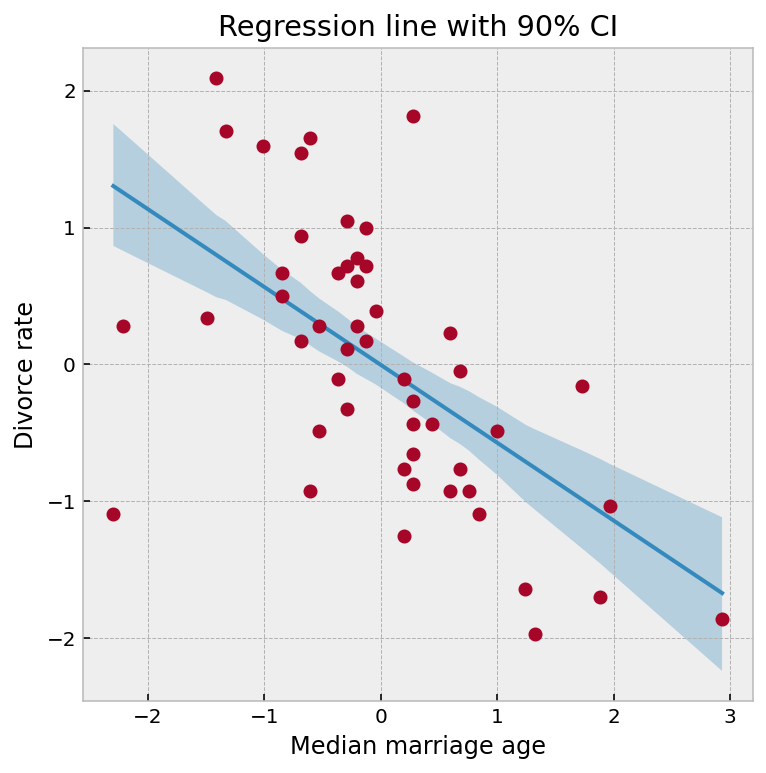

In [17]:
posterior_mu = (
    jnp.expand_dims(samples_2["a"], -1)
    + jnp.expand_dims(samples_2["bA"], -1) * dset.AgeScaled.values
)
mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.AgeScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Median marriage age",
    ylabel="Divorce rate",
    title="Regression line with 90% CI",
);

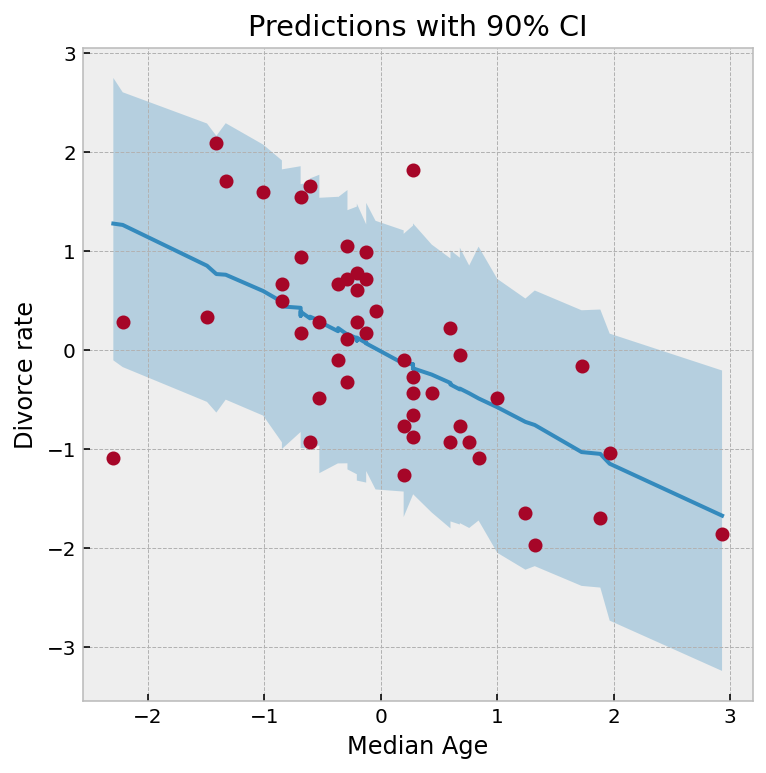

In [18]:
rng_key, rng_key_ = random.split(rng_key)
predictions_2 = Predictive(model, samples_2)(rng_key_, age=dset.AgeScaled.values)["obs"]

mean_pred = jnp.mean(predictions_2, axis=0)
hpdi_pred = hpdi(predictions_2, 0.9)

ax = plot_regression(dset.AgeScaled.values, mean_pred, hpdi_pred)
ax.set(xlabel="Median Age", ylabel="Divorce rate", title="Predictions with 90% CI");

In [19]:
rng_key, rng_key_ = random.split(rng_key)
print(
    "Log posterior predictive density: {}".format(
        log_pred_density(
            rng_key_,
            samples_2,
            model,
            age=dset.AgeScaled.values,
            divorce=dset.DivorceScaled.values,
        )
    )
)

Log posterior predictive density: -59.274169921875


In [20]:
rng_key, rng_key_ = random.split(rng_key)

mcmc.run(
    rng_key_,
    marriage=dset.MarriageScaled.values,
    age=dset.AgeScaled.values,
    divorce=dset.DivorceScaled.values,
)
mcmc.print_summary()
samples_3 = mcmc.get_samples()

  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:04<3:38:25,  4.37s/it, 1 steps of size 2.34e+00. acc. prob=0.00]

warmup:  17%|█▋        | 496/3000 [00:04<00:15, 156.91it/s, 1 steps of size 2.83e-01. acc. prob=0.79]

warmup:  28%|██▊       | 832/3000 [00:04<00:07, 295.17it/s, 3 steps of size 6.24e-01. acc. prob=0.79]

sample:  43%|████▎     | 1294/3000 [00:04<00:03, 546.61it/s, 3 steps of size 5.67e-01. acc. prob=0.92]

sample:  58%|█████▊    | 1735/3000 [00:04<00:01, 842.79it/s, 7 steps of size 5.67e-01. acc. prob=0.92]

sample:  71%|███████   | 2130/3000 [00:04<00:00, 1129.00it/s, 15 steps of size 5.67e-01. acc. prob=0.92]

sample:  86%|████████▌ | 2585/3000 [00:04<00:00, 1545.08it/s, 7 steps of size 5.67e-01. acc. prob=0.92] 

sample: 100%|██████████| 3000/3000 [00:05<00:00, 589.76it/s, 7 steps of size 5.67e-01. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.10      0.00     -0.17      0.17   2005.88      1.00
        bA     -0.61      0.15     -0.61     -0.87     -0.37   1496.72      1.00
        bM     -0.07      0.15     -0.07     -0.34      0.17   1526.17      1.00
     sigma      0.83      0.09      0.82      0.69      0.96   1752.97      1.00

Number of divergences: 0


In [21]:
rng_key, rng_key_ = random.split(rng_key)
print(
    "Log posterior predictive density: {}".format(
        log_pred_density(
            rng_key_,
            samples_3,
            model,
            marriage=dset.MarriageScaled.values,
            age=dset.AgeScaled.values,
            divorce=dset.DivorceScaled.values,
        )
    )
)

Log posterior predictive density: -59.02093505859375


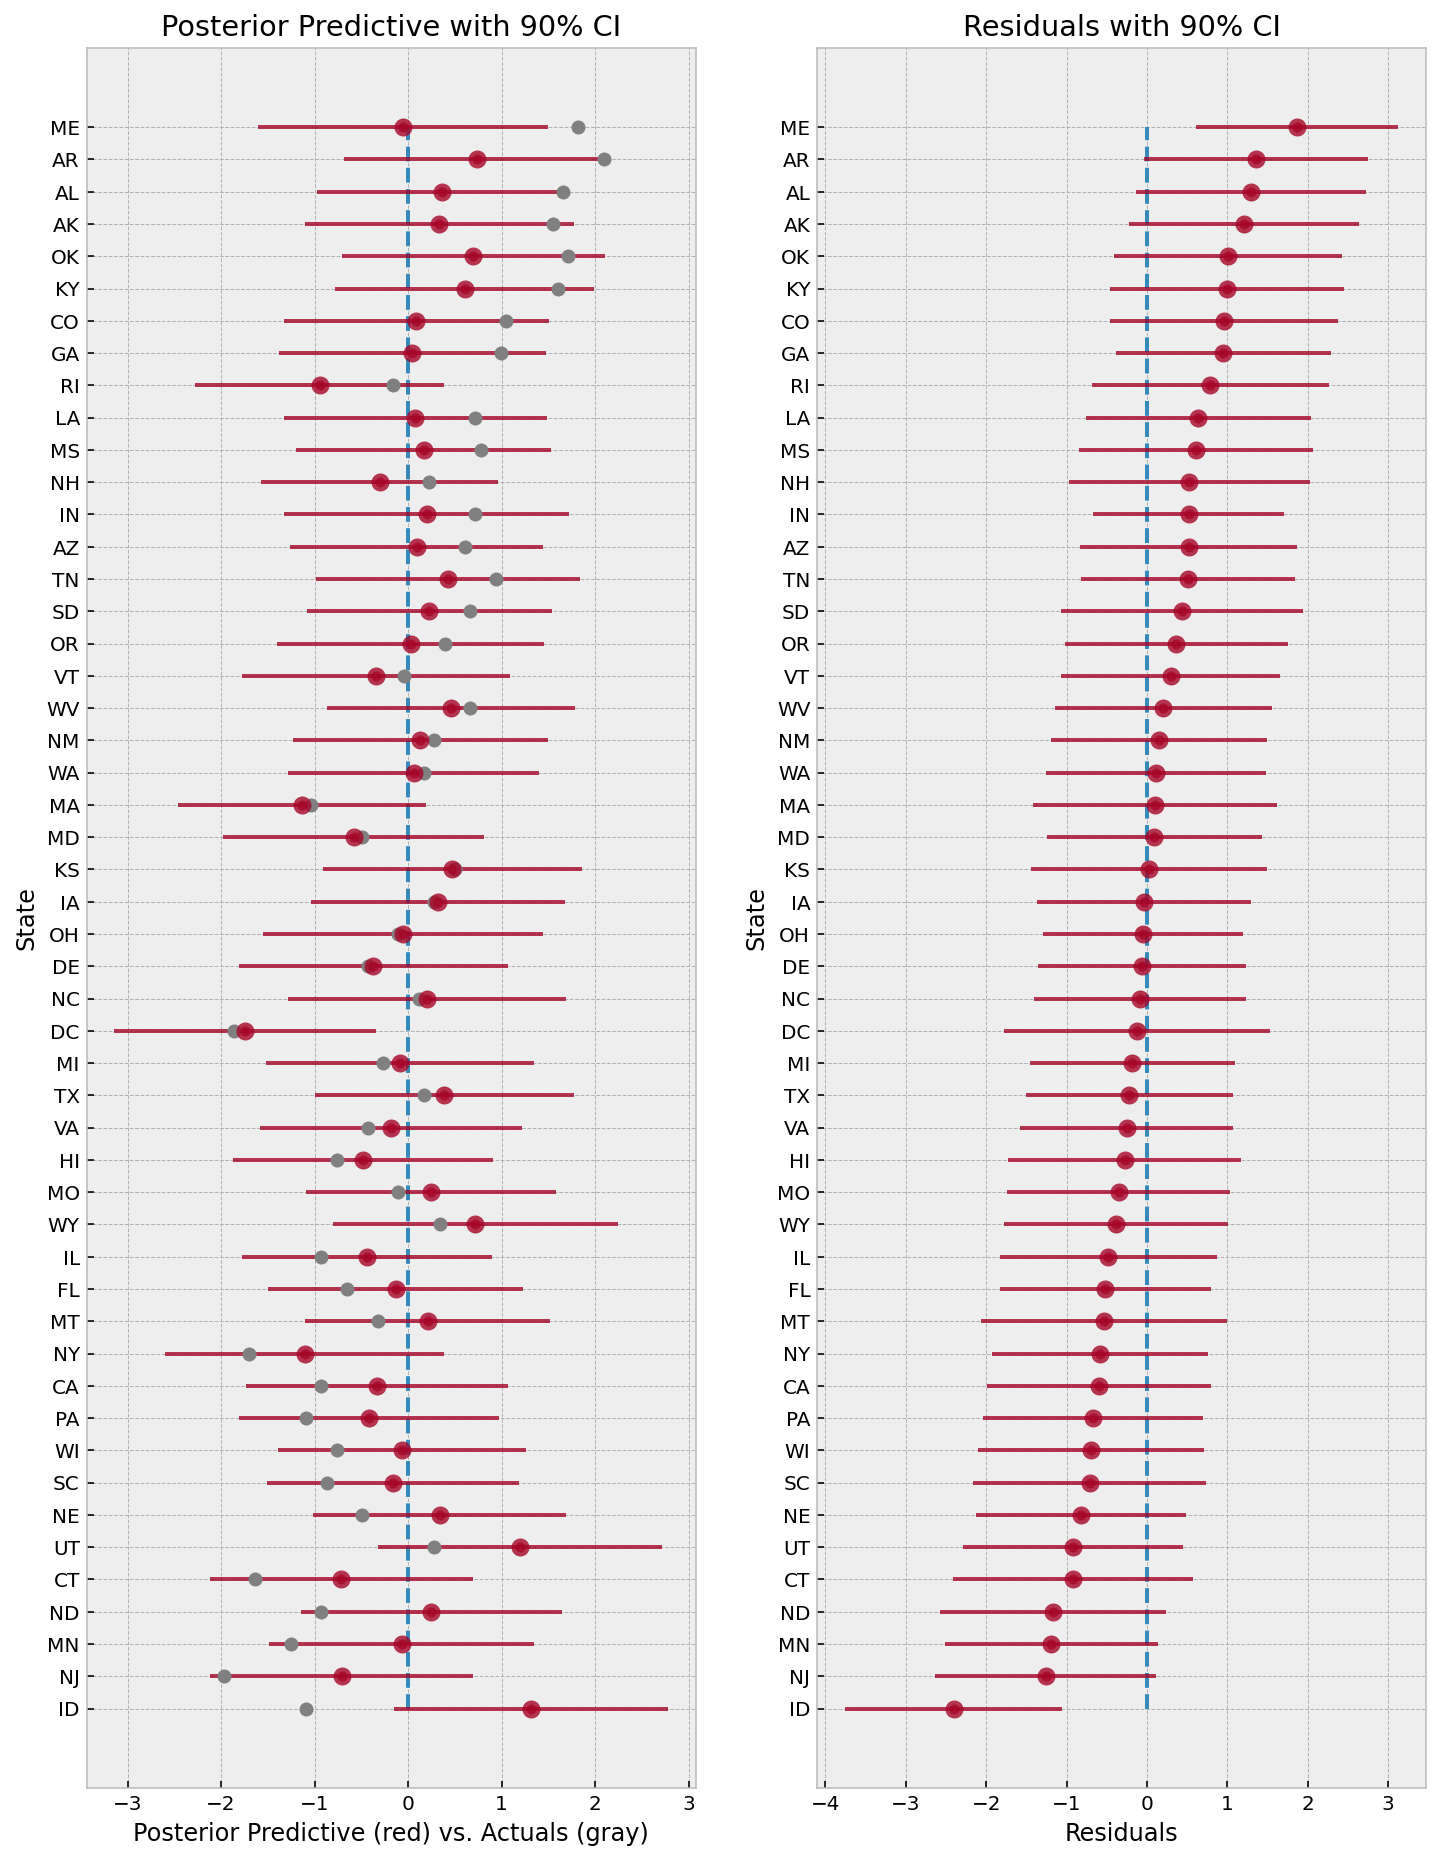

In [22]:
# Predictions for Model 3.
rng_key, rng_key_ = random.split(rng_key)
predictions_3 = Predictive(model, samples_3)(
    rng_key_, marriage=dset.MarriageScaled.values, age=dset.AgeScaled.values
)["obs"]
y = jnp.arange(50)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 16))
pred_mean = jnp.mean(predictions_3, axis=0)
pred_hpdi = hpdi(predictions_3, 0.9)
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = jnp.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
idx = jnp.argsort(residuals_mean)

# Plot posterior predictive
ax[0].plot(jnp.zeros(50), y, "--")
ax[0].errorbar(
    pred_mean[idx],
    y,
    xerr=pred_hpdi[1, idx] - pred_mean[idx],
    marker="o",
    ms=5,
    mew=4,
    ls="none",
    alpha=0.8,
)
ax[0].plot(dset.DivorceScaled.values[idx], y, marker="o", ls="none", color="gray")
ax[0].set(
    xlabel="Posterior Predictive (red) vs. Actuals (gray)",
    ylabel="State",
    title="Posterior Predictive with 90% CI",
)
ax[0].set_yticks(y)
ax[0].set_yticklabels(dset.Loc.values[idx], fontsize=10)

# Plot residuals
residuals_3 = dset.DivorceScaled.values - predictions_3
residuals_mean = jnp.mean(residuals_3, axis=0)
residuals_hpdi = hpdi(residuals_3, 0.9)
err = residuals_hpdi[1] - residuals_mean

ax[1].plot(jnp.zeros(50), y, "--")
ax[1].errorbar(
    residuals_mean[idx], y, xerr=err[idx], marker="o", ms=5, mew=4, ls="none", alpha=0.8
)
ax[1].set(xlabel="Residuals", ylabel="State", title="Residuals with 90% CI")
ax[1].set_yticks(y)
ax[1].set_yticklabels(dset.Loc.values[idx], fontsize=10);